<img src='images/Joint_school_graphic_title.png' align='center' width='100%'></img>

# Practical on Datasets Comparison and Application of Averaging Kernels

This practical exercise was created for the <a href ="https://atmosphere.copernicus.eu/3rd-eumetsatesaecmwf-joint-training-atmospheric-composition" target = "_blank">3rd EUMETSAT/ESA/ECMWF Joint Training in Atmospheric Composition (6-17 December, 2021)</a> to show how to compare the NO<sub>2</sub> observations from the TROPOspheric Monitoring Instrument (TROPOMI) aboard Sentinel 5-P and the forecasts of the Copernicus Atmosphere Monitoring Service (CAMS). It is divided into the following sections:

1. [Installation](#installation): A brief guide to know how to install the <a href = "https://github.com/esowc/adc-toolbox/" target = "_blank">Atmospheric Datasets Comparison (ADC) Toolbox</a>, which contains functions that facilitate the datasets retrieval, metadata merge and statistical analysis.

2. [Datasets retrieval](#datasets_retrieval): The model and sensor datasets are downloaded and read as xarray objects before applying the real observations kernels into the model dataset.

3. [Datasets merge](#datasets_merge): The model partial columns are interpolated into the TM5 grid and the averaging kernels are applied.

4. [Comparison analysis](#comparison_analysis): Statistical methods are used to better understand the differences between both datasets and the effects of applying the averaging kernels.

5. [Assignment](#assignment): The details about the assignment submission are included in this section.

6. [FAQ and common errors](#faq): A summary of the questions and errors that the users bumped into while completing the assignment can be found here.

7. [User feedback form](#feedback): If you want to send your feedback, in this section you will find the link to the form.

## <a id='installation'>1. Installation</a>

### Clone the repository and set up the virtual environment

Participants should <a href = "https://my.wekeo.eu/web/guest/user-registration" target = "_blank">create an account in WEkEO</a> to use the JupyterHub and run this notebook. Once they <a href = "https://jupyterhub-wekeo.apps.eumetsat.dpi.wekeo.eu" target = "_blank">have access to this service</a>, they can open the terminal and clone the ADC Toolbox repository with the command:

```bash
$ git clone https://github.com/esowc/adc-toolbox
```

The virtual environment <em>environment.yml</em> was generated to simplify the installation process, so users just need to activate this environment or simulate it by installing the dependencies (libraries and packages) with:

```bash
$ cd adc-toolbox
$ conda create --name adc-toolbox
$ conda activate adc-toolbox
$ conda install -c conda-forge/label/cartopy_dev cartopy
$ pip install -r requirements.txt
$ python -m ipykernel install --user --name adc-toolbox
```

After running the previous commands, the page should be refreshed and the correct kernel (`adc-toolbox`) should be selected.

To finalize the installation process, users need to create a text file in the <em>data</em> folder, with the name <em>keys.txt</em>, and write down their personal CAMS API key in one line with the format <em>UID:Key</em>. Alternatively, they can introduce their user ID and key in the cell underneath. This key can be obtained by <a href = "https://ads.atmosphere.copernicus.eu/user/register?">registering at the Atmosphere Data Store</a>.

In [1]:
CAMS_UID = None
CAMS_key = None

### Import libraries

In [2]:
# Related to the system
import os 
from pathlib import Path

# Related to the data retrieval
from sentinelsat.sentinel import SentinelAPI, geojson_to_wkt
import cdsapi
import cfgrib
import geojson
import urllib3

# Related to the data analysis
import math
import xarray as xr
import pandas as pd
import numpy as np
import datetime as dt
from itertools import product
import scipy.interpolate
from scipy.spatial.distance import cdist
from scipy.optimize import curve_fit
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error

# Related to the results
from copy import copy
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.colors as colors
import matplotlib.lines as mlines
import matplotlib.transforms as mtransforms
import matplotlib.ticker as mticker
import matplotlib.patches as mpatches
import cartopy.crs as ccrs
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER
import cartopy.feature as cfeature
import geocoder
import seaborn as sns
from matplotlib import animation
from IPython.display import HTML, display
import warnings

### Import functions

In [3]:
%run ../../functions/functions_general.ipynb
%run ../../functions/functions_cams.ipynb
%run ../../functions/functions_tropomi.ipynb

### Settings

In [4]:
# Hide pandas warning
pd.options.mode.chained_assignment = None

# Hide API request warning
urllib3.disable_warnings(urllib3.exceptions.InsecureRequestWarning)

# Increase animation limit
matplotlib.rcParams['animation.embed_limit'] = 25000000

# Hide labels animation warning
warnings.filterwarnings('ignore', category = UserWarning, module='cartopy')

## <a id='datasets_retrieval'>2. Datasets retrieval</a>

### Available datasets

ADC Toolbox facilitates the data retrieval of all the datasets presented in Table 1, since the dates they became available to the public. As an exception, the retrieval of IASI L2 data is currently available only since May 14, 2019.

<p align="center"> <b>Table 1</b>. Temporal availability (start date - end date) by data source.</p>

| Source | Type | Platform | NO<sub>2</sub> | O<sub>3</sub> | CO | SO<sub>2</sub> | HCHO |
| :---: | :---: | :---: | :---: | :---: | :---: | :---: | :---: |
| CAMS  | Forecast | <a href = "https://ads.atmosphere.copernicus.eu/cdsapp#!/dataset/cams-global-atmospheric-composition-forecasts" target = "_blank">ADS</a> | 01.2015 - Present | 01.2015 - Present | 01.2015 - Present | 01.2015 - Present | 01.2015 - Present | 
| CAMS  | Reanalysis | <a href = "https://ads.atmosphere.copernicus.eu/cdsapp#!/dataset/cams-global-ghg-reanalysis-egg4-monthly">ADS</a> | 01.2003 - 06.2021 | 01.2003 - 06.2021 | 01.2003 - 06.2021 | 01.2003 - 06.2021 | 01.2003 - 06.2021 | 
| TROPOMI  | L2 | <a href = "https://s5phub.copernicus.eu/dhus/" target = "_blank">S5-P hub</a> | 07.2018 - Present | 07.2018 - Present | 07.2018 - Present | 10.2018 - Present | 07.2018 - Present | 
| TROPOMI  | L3 | <a href = "https://www.temis.nl/" target = "_blank">TEMIS</a> | 07.2018 - Present | - | - | - | - | 
| IASI  | L2 | <a href = "https://iasi.aeris-data.fr/" target = "_blank">AERIS Portal</a> | - | 01.2008 - Present | 10.2007 - Present | 10.2007 - Present | - |
| IASI  | L3 | <a href = "https://iasi.aeris-data.fr/" target = "_blank">AERIS Portal</a> | - | 01.2008 - Present | 10.2007 - Present | - | - |
| GOME-2  | L2 | <a href = "https://acsaf.org/offline_access.php" target = "_blank">AC SAF</a> | 01.2007 - Present | 01.2007 - Present | - | 01.2007 - Present | 01.2007 - Present | 
| GOME-2  | L3 | <a href = "https://acsaf.org/offline_access.php" target = "_blank">AC SAF</a> | 02.2007 - 11.2017 | - | - | - | - | 
| GOME-2  | L3 | <a href = "https://www.temis.nl/" target = "_blank">TEMIS</a> | 02.2007 - Present | - | - | - | - | 

In order to automatically download any model or sensor dataset, users only need to define:

* `component_nom`: Name of the atmospheric component.
* `model`: Short name of the model (<em>cams</em>) 
* `model_full_name`: Full name of the model (<em>cams-global-atmospheric-composition-forecasts</em> or <em>cams-global-reanalysis-eac4-monthly</em>).
* `sensor`: Short name of the sensor (<em>tropomi</em>, <em>iasi</em> or <em>gome</em>).
* `start_date` and `end_date`: An array with dates will be retrieved between both dates.
* `lon_min`, `lon_max`, `lat_min` and `lat_max`: Coordinates to create the search bounding box (`bbox`).
* `area_name`: Name of the studied region.

In [5]:
# Define component
component_nom = 'NO2'

# Define model
model = 'cams'
model_full_name = 'cams-global-atmospheric-composition-forecasts'

# Define sensor
sensor = 'tropomi'
sensor_type = 'L2'
apply_kernels = True

# Define search period
start_date = '2021-11-18'
end_date = '2021-11-18'

# Define extent
area_name = 'Barcelona'
lon_min = 1.5
lon_max = 2.5
lat_min = 41
lat_max = 42

### Comparison checker and folder generation

The toolbox will check if the comparison analysis between the specified model and sensor is possible, given the name of the species. If it is, the molecular weight and the products standard metadata are obtained. Afterwards, the folders where the datasets will be stored are generated.

<ins>Note</ins>: This notebook can only be used to compare TROPOMI and CAMS datasets while applying the averaging kernels for NO<sub>2</sub>, please refer to the main code to compare the CAMS model against the observations from IASI or GOME-2 or to use the same data sources without applying the averaging kernels or for multiple timesteps.

In [6]:
# Check if comparison is possible
comparison_check(sensor, model, component_nom, model_full_name, sensor_type, apply_kernels)

# Get component full name and molecular weight
component, component_mol_weight, product_type, sensor_column, column_type = components_table(sensor, component_nom, sensor_type)

# Folders generation
generate_folders(model, sensor, component_nom, sensor_type)

The comparison is possible and will start now.


### Search period and bounding box

The search period and bounding box are derived from the details that were provided in advance.

In [7]:
# Generate array with search dates
dates = search_period(start_date, end_date, sensor, sensor_type)

# Create bbox
bbox = search_bbox(lon_min, lat_min, lon_max, lat_max)

SEARCH PERIOD
- In days: [('2021-11-18T00:00:00Z', '2021-11-18T23:00:00Z')]
SEARCH BOUNDING BOX
Latitudes: from 41 to 42
Longitudes: from 1.5 to 2.5


### Download and read the model data

The model dataset is downloaded as a GRIB file and read as a xarray object. In this step, the users can decide if they want to retrieve total (`model_level` = 'Single') or partial columns (`model_level` = 'Multiple'). For this training, we need to obtain the partial columns (at 137 vertical levels) from the <a href = "https://ads.atmosphere.copernicus.eu/cdsapp#!/dataset/cams-global-atmospheric-composition-forecasts?tab=overview" target = "_blank">CAMS global atmospheric composition forecasts</a>.

In [8]:
model_level = 'Multiple'
model_product_name, model_type = CAMS_download(dates, start_date, end_date, component, component_nom, 
                                               lat_min, lat_max, lon_min, lon_max, area_name, 
                                               model_full_name, model_level, CAMS_UID, CAMS_key)

The file exists, it will not be downloaded again.


In [9]:
model_ds, _, model_levels_df = CAMS_read(model_product_name, component, component_nom, dates)
model_ds

<xarray.Dataset>
Dimensions:     (hybrid: 137, latitude: 3, longitude: 3, step: 8, time: 1)
Coordinates:
  * time        (time) datetime64[ns] 2021-11-18
  * step        (step) timedelta64[ns] 00:00:00 03:00:00 ... 18:00:00 21:00:00
  * hybrid      (hybrid) float64 1.0 2.0 3.0 4.0 5.0 ... 134.0 135.0 136.0 137.0
  * latitude    (latitude) float64 41.0 41.4 41.8
  * longitude   (longitude) float64 1.5 1.9 2.3
    valid_time  (step) datetime64[ns] ...
Data variables:
    component   (time, step, hybrid, latitude, longitude) float32 3.873e-09 ....
Attributes:
    GRIB_edition:            2
    GRIB_centre:             ecmf
    GRIB_centreDescription:  European Centre for Medium-Range Weather Forecasts
    GRIB_subCentre:          0
    Conventions:             CF-1.7
    institution:             European Centre for Medium-Range Weather Forecasts
    history:                 2022-01-13T10:31 GRIB to CDM+CF via cfgrib-0.9.9...

### Download and read sensor data

The sensor dataset is downloaded as a `NetCDF` file and read as a xarray object, along with more detailed and support datasets. More information about this product can be found in the <a href = "https://sentinels.copernicus.eu/documents/247904/2474726/Sentinel-5P-Level-2-Product-User-Manual-Nitrogen-Dioxide.pdf/ad25ea4c-3a9a-3067-0d1c-aaa56eb1746b?t=1626258361795" target = "_blank">TROPOMI NO<sub>2</sub> product manual</a>.

In [10]:
dates = sensor_download(sensor, sensor_type, component_nom, dates, bbox, product_type)

RESULTS
For ('2021-11-18T00:00:00Z', '2021-11-18T23:00:00Z'):
You can see all the results at https://s5phub.copernicus.eu/dhus/.


2022-01-13 10:31:12,584 INFO Found 0 products
2022-01-13 10:31:12,672 INFO Found 1 products


There are no results for the processing mode NRT. The search in the offline archives will start.
Number 0-S5P_OFFL_L2__NO2____20211118T112150_20211118T130320_21240_02_020301_20211120T033928
SELECTED
File name: c0858e18-3e8d-4885-8cf1-9c57236d07e7
Product name: S5P_OFFL_L2__NO2____20211118T112150_20211118T130320_21240_02_020301_20211120T033928.nc
The file exists, it will not be downloaded again.


In [11]:
sensor_ds, support_input_ds, support_details_ds = sensor_read(sensor, sensor_type, sensor_column, 
                                                              component_nom, dates)

In [12]:
sensor_ds

<xarray.Dataset>
Dimensions:                                               (corner: 4, ground_pixel: 450, intensity_offset_polynomial_exponents: 1, layer: 34, polynomial_exponents: 6, scanline: 4173, time: 1, vertices: 2)
Coordinates:
  * scanline                                              (scanline) float64 ...
  * ground_pixel                                          (ground_pixel) float64 ...
  * time                                                  (time) datetime64[ns] ...
  * corner                                                (corner) float64 0....
  * polynomial_exponents                                  (polynomial_exponents) float64 ...
  * intensity_offset_polynomial_exponents                 (intensity_offset_polynomial_exponents) float64 ...
  * layer                                                 (layer) float64 0.0...
  * vertices                                              (vertices) float64 ...
    latitude                                              (time, scanline, ground_pixel) float32 ...
    longitude                                             (time, scanline, ground_pixel) float32 ...
Data variables:
    delta_time                                            (time, scanline) datetime64[ns] ...
    time_utc                                              (time, scanline) object ...
    qa_value                                              (time, scanline, ground_pixel) float32 ...
    sensor_column                                         (time, scanline, ground_pixel) float32 ...
    nitrogendioxide_tropospheric_column_precision         (time, scanline, ground_pixel) float32 ...
    nitrogendioxide_tropospheric_column_precision_kernel  (time, scanline, ground_pixel) float32 ...
    averaging_kernel                                      (time, scanline, ground_pixel, layer) float32 ...
    air_mass_factor_troposphere                           (time, scanline, ground_pixel) float32 ...
    air_mass_factor_total                                 (time, scanline, ground_pixel) float32 ...
    tm5_tropopause_layer_index                            (time, scanline, ground_pixel) float64 ...
    tm5_constant_a                                        (time, layer, vertices) float32 ...
    tm5_constant_b                                        (time, layer, vertices) float32 ...

Within `support_input_ds` and `support_details_ds` we find the surface pressure data, that we will need to compute the pressure at each level.

In [13]:
support_input_ds

<xarray.Dataset>
Dimensions:                                (ground_pixel: 450, scanline: 4173, time: 1)
Coordinates:
  * time                                   (time) datetime64[ns] 2021-11-18
  * scanline                               (scanline) float64 0.0 ... 4.172e+03
  * ground_pixel                           (ground_pixel) float64 0.0 ... 449.0
Data variables: (12/18)
    surface_altitude                       (time, scanline, ground_pixel) float32 ...
    surface_altitude_precision             (time, scanline, ground_pixel) float32 ...
    surface_classification                 (time, scanline, ground_pixel) float32 ...
    instrument_configuration_identifier    (time, scanline) float64 20.0 ... ...
    instrument_configuration_version       (time, scanline) float32 24.0 ... ...
    scaled_small_pixel_variance            (time, scanline, ground_pixel) float32 ...
    ...                                     ...
    cloud_fraction_crb                     (time, scanline, ground_pixel) float32 ...
    cloud_albedo_crb                       (time, scanline, ground_pixel) float32 ...
    scene_albedo                           (time, scanline, ground_pixel) float32 ...
    apparent_scene_pressure                (time, scanline, ground_pixel) float32 ...
    snow_ice_flag                          (time, scanline, ground_pixel) float32 ...
    aerosol_index_354_388                  (time, scanline, ground_pixel) float32 ...

In [14]:
support_details_ds

<xarray.Dataset>
Dimensions:                                                (ground_pixel: 450, intensity_offset_polynomial_exponents: 1, polynomial_exponents: 6, scanline: 4173, time: 1)
Coordinates:
  * time                                                   (time) datetime64[ns] ...
  * scanline                                               (scanline) float64 ...
  * ground_pixel                                           (ground_pixel) float64 ...
Dimensions without coordinates: intensity_offset_polynomial_exponents, polynomial_exponents
Data variables: (12/45)
    processing_quality_flags                               (time, scanline, ground_pixel) float64 ...
    number_of_spectral_points_in_retrieval                 (time, scanline, ground_pixel) float32 ...
    number_of_iterations                                   (time, scanline, ground_pixel) float64 ...
    wavelength_calibration_offset                          (time, scanline, ground_pixel) float32 ...
    wavelength_calibration_offset_precision                (time, scanline, ground_pixel) float32 ...
    wavelength_calibration_stretch                         (time, scanline, ground_pixel) float32 ...
    ...                                                     ...
    degrees_of_freedom                                     (time, scanline, ground_pixel) float32 ...
    air_mass_factor_stratosphere                           (time, scanline, ground_pixel) float32 ...
    air_mass_factor_cloudy                                 (time, scanline, ground_pixel) float32 ...
    air_mass_factor_clear                                  (time, scanline, ground_pixel) float32 ...
    nitrogendioxide_ghost_column                           (time, scanline, ground_pixel) float32 ...
    cloud_selection_flag                                   (time, scanline, ground_pixel) float32 ...

## <a id='datasets_merge'>3. Datasets merge</a>

We will apply the sensor averaging kernels to the model partial columns in the observations space (TM5) before comparing the datasets. Right now, we have data at different grid resolutions and levels: the sensor collects data at 34 vertical layers, which are broader than the 137 levels in the CAMS model.

<img src='images/Vertical_resolutions.png' align='center' width='50%'></img>

<center><b>Figure 1.</b> L137 and TM5 levels by pressure.</center>


### Steps

Following the next steps, we can retrieve the model partial columns at the TM5 grid and carry out the satellite datasets comparison:
1. (L137) Calculate model levels pressure.
2. (L137) Convert model data units (from kg/kg to molecules/cm<sup>2</sup>) and compute the partial columns above each half level in the model space. 
3. (TM5) Calculate sensor levels pressure and column kernels.
4. (TM5) Convert sensor data units (from kg/m<sup>2</sup> to molecules/cm<sup>2</sup>).
5. (TM5 + L137) Transform sensor dataset into a dataframe and join L137 and TM5 levels.
6. (L137) Retrieve model partial columns above each level by closest neighbours.
7. (TM5) Interpolate model partial columns above each level in the observations space.
8. (TM5) Calculate model partial columns at each level.
9. (TM5) Apply averaging kernels.
10. (TM5) Calculate total columns for both datasets and difference between them.

### Calculate the model levels pressure

The 137 vertical levels in the model can be described by various parameters, which are necessary to evaluate the levels pressure. In particular, the coefficients `a` and `b` are used, as indicated in the <a href = "https://confluence.ecmwf.int/display/OIFS/4.4+OpenIFS%3A+Vertical+Resolution+and+Configurations">Confluence page about the vertical resolution and configuration of the model</a>, to calculate these pressures:

<center>
<em>p<sub>k+½</sub> = a<sub>k+½</sub> + p<sub>s</sub> · b<sub>k+½</sub></em><br>
<em>p<sub>k-½</sub> = a<sub>k-½</sub> + p<sub>s</sub> · b<sub>k-½</sub></em><br>
<em>p<sub>k</sub> = 0.5 · (p<sub>k-½</sub> + p<sub>k+½</sub>)</em>
</center>

In [15]:
model_levels_df

,a [Pa],b,ph [hPa],pf [hPa],Geopotential Altitude [m],Geometric Altitude [m],Temperature [K],Density [kg/m^3],ph [Pa],Depth [m]
hybrid,,,,,,,,,,
1,2.000365,0.000000,0.0200,0.0100,79301.79,80301.65,198.05,0.000018,2.00,5580.21
2,3.102241,0.000000,0.0310,0.0255,73721.58,74584.91,209.21,0.000042,3.10,2605.83
3,4.666084,0.000000,0.0467,0.0388,71115.75,71918.79,214.42,0.000063,4.67,2497.32
4,6.827977,0.000000,0.0683,0.0575,68618.43,69365.77,221.32,0.000090,6.83,2407.44
5,9.746966,0.000000,0.0975,0.0829,66210.99,66906.53,228.06,0.000127,9.75,2320.96
...,...,...,...,...,...,...,...,...,...,...
133,62.781250,0.988500,1002.2250,1000.5165,106.54,106.54,287.46,1.212498,100222.50,27.50
134,22.835938,0.991984,1005.3562,1003.7906,79.04,79.04,287.64,1.215710,100535.62,25.12
135,3.757813,0.995003,1008.2239,1006.7900,53.92,53.92,287.80,1.218650,100822.39,22.96


In [16]:
# Calculate level pressures from the surface pressures
model_ds = CAMS_pressure(model_ds, model_product_name, model_levels_df, start_date, end_date, component_nom, 
                         lat_min, lat_max, lon_min, lon_max, area_name, CAMS_UID, CAMS_key)
model_ds

2022-01-13 10:31:28,946 INFO Welcome to the CDS
2022-01-13 10:31:28,947 INFO Sending request to https://ads.atmosphere.copernicus.eu/api/v2/resources/cams-global-atmospheric-composition-forecasts
2022-01-13 10:31:29,011 INFO Request is completed
2022-01-13 10:31:29,012 INFO Downloading https://download-0001.copernicus-atmosphere.eu/cache-compute-0001/cache/data0/adaptor.mars_constrained.external-1641809961.6149287-7135-16-fe54cc39-cdc8-4487-bf1a-247256a15b8f.grib to /home/alba/adc-toolbox/data/cams/NO2/CAMS_FORECAST_SURFACE_PRESSURE_2021-11-18_2021-11-18_Barcelona.grib (1008)
2022-01-13 10:31:29,095 INFO Download rate 11.9K/s
2022-01-13 10:31:29,107 WARNING Ignoring index file '/home/alba/adc-toolbox/data/cams/NO2/CAMS_FORECAST_SURFACE_PRESSURE_2021-11-18_2021-11-18_Barcelona.grib.923a8.idx' older than GRIB file


<xarray.Dataset>
Dimensions:     (hybrid: 137, latitude: 3, longitude: 3, step: 8, time: 1)
Coordinates:
  * time        (time) datetime64[ns] 2021-11-18
  * step        (step) timedelta64[ns] 00:00:00 03:00:00 ... 18:00:00 21:00:00
  * hybrid      (hybrid) float64 1.0 2.0 3.0 4.0 5.0 ... 134.0 135.0 136.0 137.0
  * latitude    (latitude) float64 41.0 41.4 41.8
  * longitude   (longitude) float64 1.5 1.9 2.3
    valid_time  (step) datetime64[ns] 2021-11-18 ... 2021-11-18T21:00:00
Data variables:
    component   (time, step, hybrid, latitude, longitude) float32 3.873e-09 ....
    pressure    (hybrid, time, step, latitude, longitude) float64 1.0 ... 9.6...
Attributes:
    GRIB_edition:            2
    GRIB_centre:             ecmf
    GRIB_centreDescription:  European Centre for Medium-Range Weather Forecasts
    GRIB_subCentre:          0
    Conventions:             CF-1.7
    institution:             European Centre for Medium-Range Weather Forecasts
    history:                 2022-01-13T10:31 GRIB to CDM+CF via cfgrib-0.9.9...

### Convert the model data units (from kg/kg to molecules/cm<sup>2</sup>)

#### Calculate the columns above each half level (kg/kg to kg/m<sup>2</sup>)
To convert the original units (kg/kg) into kg/m<sup>2</sup>, we calculate the NO<sub>2</sub> columns above each CAMS half level, assuming that they are 0 at the top of the atmosphere.

In [17]:
print('The columns above each model half level will be calculated.')

# Initialize partial columns at the top of the atmosphere (hybrid = 1) as 0
model_ds_time_old = model_ds.sel(time = model_ds.time.values[0])
PC_hybrid_0 = model_ds_time_old.sel(hybrid = 1)
PC_hybrid_0['component'] = PC_hybrid_0['component'].where(PC_hybrid_0['component'] <= 0, 0, drop = False)
PC_hybrid_0 = PC_hybrid_0.expand_dims(dim = ['hybrid'])

# Create new model dataset
PC_above_all = []
PC_above_all.append(PC_hybrid_0)
model_ds_time_new = PC_hybrid_0

for hybrid in range(1, 137):

    # Get current and previous partial columns and level pressures
    PC_last = model_ds_time_new.component.sel(hybrid = hybrid)
    PC_current = model_ds_time_old.component.sel(hybrid = hybrid + 1)
    pressure_last = model_ds_time_old.pressure.sel(hybrid = hybrid)
    pressure_current = model_ds_time_old.pressure.sel(hybrid = hybrid + 1)

    # Calculate pressure difference
    pressure_diff = pressure_current - pressure_last

    # Calculate partial columns above each model level
    # Units: (kg/kg * kg/m*s2) * s2/m -> kg/m2
    PC_above = model_ds_time_old.sel(hybrid = hybrid + 1)
    PC_above['component'] = PC_last + PC_current * pressure_diff * (1/9.81)

    # Append result
    PC_above_all.append(PC_above)
    model_ds_time_new = xr.concat(PC_above_all, pd.Index(range(1, hybrid + 2), name = 'hybrid'))

model_ds = model_ds_time_new
model_ds = model_ds.expand_dims(dim = ['time'])
model_ds

The columns above each model half level will be calculated.


<xarray.Dataset>
Dimensions:     (hybrid: 137, latitude: 3, longitude: 3, step: 8, time: 1)
Coordinates:
  * time        (time) datetime64[ns] 2021-11-18
  * step        (step) timedelta64[ns] 00:00:00 03:00:00 ... 18:00:00 21:00:00
  * hybrid      (hybrid) int64 1 2 3 4 5 6 7 8 ... 131 132 133 134 135 136 137
  * latitude    (latitude) float64 41.0 41.4 41.8
  * longitude   (longitude) float64 1.5 1.9 2.3
    valid_time  (step) datetime64[ns] 2021-11-18 ... 2021-11-18T21:00:00
Data variables:
    component   (time, hybrid, step, latitude, longitude) float64 0.0 ... 7.0...
    pressure    (time, hybrid, step, latitude, longitude) float64 1.0 ... 9.6...
Attributes:
    GRIB_edition:            2
    GRIB_centre:             ecmf
    GRIB_centreDescription:  European Centre for Medium-Range Weather Forecasts
    GRIB_subCentre:          0
    Conventions:             CF-1.7
    institution:             European Centre for Medium-Range Weather Forecasts
    history:                 2022-01-13T10:31 GRIB to CDM+CF via cfgrib-0.9.9...

In [18]:
# Assign new units to array
units = 'kg m**-2'
model_ds['component'] = model_ds.component.assign_attrs({'units': units})
print('The model component units have been converted from kg kg**-1 to kg m**-2.')

The model component units have been converted from kg kg**-1 to kg m**-2.


#### Convert units with Avogadro's number (kg/m<sup>2</sup> to molecules/cm<sup>2</sup>)

After, we convert the data units from kg/m<sup>2</sup> to molecules/cm<sup>2</sup> simply by:

In [19]:
# Conversion
NA = 6.022*10**23
model_ds['component'] = (model_ds['component'] * NA * 1000) / (10000 * component_mol_weight)

In [20]:
# Assign new units to array
model_ds['component'] = model_ds.component.assign_attrs({'units': 'molec cm-2'})
print('The model component units have been converted from kg m**-2 to molec cm-2.')

The model component units have been converted from kg m**-2 to molec cm-2.


### Calculate the TM5 levels pressure and column kernels

The computation of TM5 levels pressure is carried out as explained before. On the other hand, the tropospheric column kernels equal to:
<center>
<em>A<sub>trop</sub> = (M · A)/M<sub>trop</sub> if l $\leq$ l<sub>trop</sub></em><br>
<em>A<sub>trop</sub> = 0 if l $\gt$ l<sub>trop</sub></em><br><br>
</center>
where <em>A</em> is the total averaging kernel, <em>M</em> the total air mass factor, <em>M<sub>trop</sub></em> the tropospheric air mass factor, <em>l</em> the layer and <em>l<sub>trop</sub></em> the last layer of the troposphere.

In [21]:
print('APPLICATION OF AVERAGING KERNELS')
print('For the application of the averaging kernels, it is necessary to calculate:')
print('1. Level pressures')
print('2. Column kernels')
print('The apriori profiles should be retrieved, but they are not necessary.')

print('DATA AVAILABILITY')
sensor_ds = TROPOMI_pressure(sensor_ds, component_nom, support_input_ds, support_details_ds)
sensor_ds = TROPOMI_column_kernel(sensor_ds, component_nom, support_details_ds)
sensor_ds = TROPOMI_apriori_profile(sensor_ds, component_nom, component, support_details_ds)

APPLICATION OF AVERAGING KERNELS
For the application of the averaging kernels, it is necessary to calculate:
1. Level pressures
2. Column kernels
The apriori profiles should be retrieved, but they are not necessary.
DATA AVAILABILITY
The level pressures will be calculated.
The column kernels will be calculated.
The dataset does not contain any apriori profile.


In [22]:
sensor_ds

<xarray.Dataset>
Dimensions:                                               (corner: 4, ground_pixel: 450, intensity_offset_polynomial_exponents: 1, layer: 34, polynomial_exponents: 6, scanline: 4173, time: 1, vertices: 2)
Coordinates:
  * scanline                                              (scanline) float64 ...
  * ground_pixel                                          (ground_pixel) float64 ...
  * time                                                  (time) datetime64[ns] ...
  * corner                                                (corner) float64 0....
  * polynomial_exponents                                  (polynomial_exponents) float64 ...
  * intensity_offset_polynomial_exponents                 (intensity_offset_polynomial_exponents) float64 ...
  * layer                                                 (layer) float64 0.0...
  * vertices                                              (vertices) float64 ...
    latitude                                              (time, scanline, ground_pixel) float32 ...
    longitude                                             (time, scanline, ground_pixel) float32 ...
Data variables: (12/14)
    delta_time                                            (time, scanline) datetime64[ns] ...
    time_utc                                              (time, scanline) object ...
    qa_value                                              (time, scanline, ground_pixel) float32 ...
    sensor_column                                         (time, scanline, ground_pixel) float32 ...
    nitrogendioxide_tropospheric_column_precision         (time, scanline, ground_pixel) float32 ...
    nitrogendioxide_tropospheric_column_precision_kernel  (time, scanline, ground_pixel) float32 ...
    ...                                                    ...
    air_mass_factor_total                                 (time, scanline, ground_pixel) float32 ...
    tm5_tropopause_layer_index                            (time, scanline, ground_pixel) float64 ...
    tm5_constant_a                                        (time, layer, vertices) float32 ...
    tm5_constant_b                                        (time, layer, vertices) float32 ...
    pressure                                              (time, layer, scanline, ground_pixel) float32 ...
    column_kernel                                         (layer, time, scanline, ground_pixel) float32 ...

### Convert TROPOMI data units (From mol/m<sup>2</sup> to molecules/cm<sup>2</sup>)

In [23]:
# Conversion
sensor_ds['sensor_column'] = sensor_ds['sensor_column'] * 6.02214*10**19

In [24]:
# Assign new units to array
sensor_ds['sensor_column'] = sensor_ds['sensor_column'].assign_attrs({'units': 'molec cm-2'})
print('The sensor component units have been converted from mol cm-2 to molec cm-2.')

The sensor component units have been converted from mol cm-2 to molec cm-2.


### Transform sensor dataset into a dataframe and join L137 and TM5 levels

Before we transform the sensor dataset into a dataframe, we select the data for a unique date and subset both datasets to speed up the merge. CAMS dataset was already reduced to the size of the previously defined bounding box during the units conversion. To subset TROPOMI's dataset, we create a lookup table with the equivalent geospatial coordinates to each pair of scanline and ground pixel.

In [25]:
# Reduce data to only one timestamp
model_ds_time = model_ds.sel(time = model_ds.time.values)
sensor_ds_time = sensor_ds.sel(time = sensor_ds.time.values)

In [26]:
# Subset
sensor_ds_time = subset(sensor_ds_time, bbox, sensor, component_nom, 
                        sensor_type, subset_type = 'sensor_subset')

# Get equivalence table for coordinates after subset
lookup_table = TROPOMI_lookup_table(sensor_ds_time, component_nom)

In [27]:
lookup_table

,ground_pixel,scanline,time,latitude,longitude,delta_time
0,104.0,3294.0,2021-11-18,40.749073,1.652233,2021-11-18 12:29:32.250
1,104.0,3295.0,2021-11-18,40.797028,1.631040,2021-11-18 12:29:33.090
2,104.0,3296.0,2021-11-18,40.844955,1.609886,2021-11-18 12:29:33.930
3,104.0,3297.0,2021-11-18,40.892921,1.588636,2021-11-18 12:29:34.770
4,104.0,3298.0,2021-11-18,40.940891,1.567341,2021-11-18 12:29:35.610
...,...,...,...,...,...,...
547,126.0,3313.0,2021-11-18,42.045448,2.451250,2021-11-18 12:29:48.210
548,126.0,3314.0,2021-11-18,42.093525,2.430267,2021-11-18 12:29:49.050
549,126.0,3315.0,2021-11-18,42.141617,2.409233,2021-11-18 12:29:49.890
550,126.0,3316.0,2021-11-18,42.189697,2.388215,2021-11-18 12:29:50.730


In [28]:
# Transform data array into dataframe
match_df_time = sensor_ds_time.to_dataframe()

# Pass NaNs to data with qa_value under 0.5 (these values will be shown as transparent)
match_df_time.loc[match_df_time['qa_value'] <= 0.5, ['sensor_column', 'column_kernel']] = float('NaN')

# Select multiindex elements
match_df_time = match_df_time.groupby(by = ['layer', 'scanline', 'ground_pixel', 'time', 'delta_time']).mean()
match_df_time = match_df_time.reset_index(level = ['layer', 'delta_time'])
match_df_time = match_df_time.set_index('layer', append = True)

In [29]:
match_df_time

delta_time   latitude  \
scanline ground_pixel time       layer                                      
3294.0   104.0        2021-11-18 0.0   2021-11-18 12:29:32.250  40.749073   
         105.0        2021-11-18 0.0   2021-11-18 12:29:32.250  40.768257   
         106.0        2021-11-18 0.0   2021-11-18 12:29:32.250  40.787251   
         107.0        2021-11-18 0.0   2021-11-18 12:29:32.250  40.806057   
         108.0        2021-11-18 0.0   2021-11-18 12:29:32.250  40.824673   
...                                                        ...        ...   
3317.0   122.0        2021-11-18 33.0  2021-11-18 12:29:51.570  42.173199   
         123.0        2021-11-18 33.0  2021-11-18 12:29:51.570  42.189560   
         124.0        2021-11-18 33.0  2021-11-18 12:29:51.570  42.205772   
         125.0        2021-11-18 33.0  2021-11-18 12:29:51.570  42.221844   
         126.0        2021-11-18 33.0  2021-11-18 12:29:51.570  42.237774   

                                        longitude  qa_value  sensor_column  \
scanline ground_pixel time       layer                                       
3294.0   104.0        2021-11-18 0.0     1.652233      0.74   3.095303e+15   
         105.0        2021-11-18 0.0     1.709576      0.74   2.979195e+15   
         106.0        2021-11-18 0.0     1.766579      0.74   2.523980e+15   
         107.0        2021-11-18 0.0     1.823249      0.74   3.217050e+15   
         108.0        2021-11-18 0.0     1.879590      0.74   2.826590e+15   
...                                           ...       ...            ...   
3317.0   122.0        2021-11-18 33.0    2.157079      1.00   1.414198e+15   
         123.0        2021-11-18 33.0    2.209967      1.00   2.486753e+15   
         124.0        2021-11-18 33.0    2.262609      1.00   2.677387e+15   
         125.0        2021-11-18 33.0    2.315008      1.00   1.854234e+15   
         126.0        2021-11-18 33.0    2.367170      1.00   3.465692e+15   

                                        nitrogendioxide_tropospheric_column_precision  \
scanline ground_pixel time       layer                                                  
3294.0   104.0        2021-11-18 0.0                                         0.000016   
         105.0        2021-11-18 0.0                                         0.000016   
         106.0        2021-11-18 0.0                                         0.000014   
         107.0        2021-11-18 0.0                                         0.000016   
         108.0        2021-11-18 0.0                                         0.000015   
...                                                                               ...   
3317.0   122.0        2021-11-18 33.0                                        0.000014   
         123.0        2021-11-18 33.0                                        0.000017   
         124.0        2021-11-18 33.0                                        0.000018   
         125.0        2021-11-18 33.0                                        0.000015   
         126.0        2021-11-18 33.0                                        0.000021   

                                        nitrogendioxide_tropospheric_column_precision_kernel  \
scanline ground_pixel time       layer                                                         
3294.0   104.0        2021-11-18 0.0                                             0.000012      
         105.0        2021-11-18 0.0                                             0.000012      
         106.0        2021-11-18 0.0                                             0.000012      
         107.0        2021-11-18 0.0                                             0.000012      
         108.0        2021-11-18 0.0                                             0.000012      
...                                                                                   ...      
3317.0   122.0        2021-11-18 33.0                                            0.000013      
         123.

In [30]:
# Create index that includes CAMS pressure levels for all the locations in TROPOMI
new_array = np.concatenate([np.arange(1, 137) * 1000, sensor_ds_time.layer.values])
new_index = pd.MultiIndex.from_product([match_df_time.index.levels[0], 
                                        match_df_time.index.levels[1],
                                        match_df_time.index.levels[2],
                                        new_array
                                        ],
                                        names = ['scanline', 'ground_pixel', 'time', 'layer'])

# Append original and new indexes and reindex dataframe
match_df_time = match_df_time[~match_df_time.index.duplicated()]
match_df_time = match_df_time.reindex(match_df_time.index.append(new_index))

# Sort and reset index
match_df_time = match_df_time.sort_index()
match_df_time = match_df_time.reset_index()

In [31]:
match_df_time

,scanline,ground_pixel,time,layer,delta_time,latitude,longitude,qa_value,sensor_column,nitrogendioxide_tropospheric_column_precision,nitrogendioxide_tropospheric_column_precision_kernel,averaging_kernel,air_mass_factor_troposphere,air_mass_factor_total,tm5_tropopause_layer_index,tm5_constant_a,tm5_constant_b,pressure,column_kernel
0,3294.0,104.0,2021-11-18,0.0,2021-11-18 12:29:32.250,40.749073,1.652233,0.74,3.095303e+15,0.000016,0.000012,0.075381,1.08736,1.99903,16.0,11.417969,0.995992,102036.546875,0.138583
1,3294.0,104.0,2021-11-18,0.0,2021-11-18 12:29:32.250,40.749073,1.652233,0.74,3.095303e+15,0.000016,0.000012,0.075381,1.08736,1.99903,16.0,11.417969,0.995992,102036.546875,0.138583
2,3294.0,104.0,2021-11-18,1.0,2021-11-18 12:29:32.250,40.749073,1.652233,0.74,3.095303e+15,0.000016,0.000012,0.091888,1.08736,1.99903,16.0,223.625000,0.980749,100687.281250,0.168929
3,3294.0,104.0,2021-11-18,1.0,2021-11-18 12:29:32.250,40.749073,1.652233,0.74,3.095303e+15,0.000016,0.000012,0.091888,1.08736,1.99903,16.0,223.625000,0.980749,100687.281250,0.168929
4,3294.0,104.0,2021-11-18,2.0,2021-11-18 12:29:32.250,40.749073,1.652233,0.74,3.095303e+15,0.000016,0.000012,0.101803,1.08736,1.99903,16.0,905.980469,0.950697,98291.289062,0.187158
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
112603,3317.0,126.0,2021-11-18,132000.0,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
112604,3317.0,126.0,2021-11-18,133000.0,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
112605,3317.0,126.0,2021-11-18,134000.0,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
112606,3317.0,126.0,2021-11-18,135000.0,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


### Retrieve CAMS partial columns at TM5 grid

In [32]:
# Find latitudes in CAMS rows with scanlines and ground pixels
match_df_time['latitude'] = match_df_time.apply(lambda row: float(lookup_table[
                                                            (lookup_table['scanline'] == row['scanline']) & 
                                                            (lookup_table['ground_pixel'] == row['ground_pixel'])]['latitude'])
                                                            if pd.isnull(row['latitude']) 
                                                            else row['latitude'], 
                                                            axis = 1)

In [33]:
# Find longitudes in CAMS rows with scanlines and ground pixels
match_df_time['longitude'] = match_df_time.apply(lambda row: float(lookup_table[
                                                             (lookup_table['scanline'] == row['scanline']) & 
                                                             (lookup_table['ground_pixel'] == row['ground_pixel'])]['longitude'])
                                                             if pd.isnull(row['longitude']) 
                                                             else row['longitude'], 
                                                             axis = 1)

In [34]:
# Get unique timestep
sensor_times = sensor_ds_time.delta_time.isel(scanline = 0).values
model_times = model_ds_time.valid_time.values
unique_step = int(np.unique(nearest_neighbour(model_times, sensor_times)))
unique_time = model_ds_time.component.isel(step = unique_step).step.values.astype('timedelta64[h]')

# Get CAMS model partial columns above each level at closest TROPOMI locations (nearest neighbours)
match_df_time['model_partial_column_above'] = match_df_time.apply(lambda row: model_ds_time.component.sel(
                                                                              step = unique_time,
                                                                              hybrid = row['layer'] / 1000, 
                                                                              latitude = row['latitude'], 
                                                                              longitude = row['longitude'], 
                                                                              method = 'nearest').values 
                                                                              if pd.isnull(row['sensor_column']) 
                                                                              else math.nan,
                                                                              axis = 1)

In [35]:
match_df_time

,scanline,ground_pixel,time,layer,delta_time,latitude,longitude,qa_value,sensor_column,nitrogendioxide_tropospheric_column_precision,nitrogendioxide_tropospheric_column_precision_kernel,averaging_kernel,air_mass_factor_troposphere,air_mass_factor_total,tm5_tropopause_layer_index,tm5_constant_a,tm5_constant_b,pressure,column_kernel,model_partial_column_above
0,3294.0,104.0,2021-11-18,0.0,2021-11-18 12:29:32.250,40.749073,1.652233,0.74,3.095303e+15,0.000016,0.000012,0.075381,1.08736,1.99903,16.0,11.417969,0.995992,102036.546875,0.138583,NaN
1,3294.0,104.0,2021-11-18,0.0,2021-11-18 12:29:32.250,40.749073,1.652233,0.74,3.095303e+15,0.000016,0.000012,0.075381,1.08736,1.99903,16.0,11.417969,0.995992,102036.546875,0.138583,NaN
2,3294.0,104.0,2021-11-18,1.0,2021-11-18 12:29:32.250,40.749073,1.652233,0.74,3.095303e+15,0.000016,0.000012,0.091888,1.08736,1.99903,16.0,223.625000,0.980749,100687.281250,0.168929,NaN
3,3294.0,104.0,2021-11-18,1.0,2021-11-18 12:29:32.250,40.749073,1.652233,0.74,3.095303e+15,0.000016,0.000012,0.091888,1.08736,1.99903,16.0,223.625000,0.980749,100687.281250,0.168929,NaN
4,3294.0,104.0,2021-11-18,2.0,2021-11-18 12:29:32.250,40.749073,1.652233,0.74,3.095303e+15,0.000016,0.000012,0.101803,1.08736,1.99903,16.0,905.980469,0.950697,98291.289062,0.187158,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
112603,3317.0,126.0,2021-11-18,132000.0,NaT,42.237774,2.367170,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,[3514948453259192.0]
112604,3317.0,126.0,2021-11-18,133000.0,NaT,42.237774,2.367170,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,[3656977341598510.5]
112605,3317.0,126.0,2021-11-18,134000.0,NaT,42.237774,2.367170,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,[3789650794282319.0]
112606,3317.0,126.0,2021-11-18,135000.0,NaT,42.237774,2.367170,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,[3914314582781044.5]


### Interpolate CAMS partial columns above each level at TM5 pressures

In [36]:
# Get CAMS model level pressures
match_df_time['pressure'] = match_df_time.apply(lambda row: model_ds_time.pressure.sel(
                                                            step = unique_time,
                                                            hybrid = row['layer'] / 1000, 
                                                            latitude = row['latitude'], 
                                                            longitude = row['longitude'], 
                                                            method = 'nearest').values 
                                                            if pd.isnull(row['pressure']) 
                                                            else row['pressure'],
                                                            axis = 1)

# Transform 1D-array data to float
match_df_time['model_partial_column_above'] = match_df_time['model_partial_column_above'].apply(lambda x: float(x))
match_df_time['pressure'] = match_df_time['pressure'].apply(lambda x: float(x))

# Set multiindex again and sort for interpolation
match_df_time = match_df_time.reset_index()
match_df_time = match_df_time.set_index(['time', 'ground_pixel', 'scanline', 'pressure'])
match_df_time = match_df_time.sort_values(['time', 'ground_pixel','scanline', 'pressure'], 
                                          ascending = [True, True, True, False])

# Interpolate partial columns onto the TM5 pressure levels
match_df_time = match_df_time[~match_df_time.index.duplicated()]
match_df_time['model_partial_column_above'] = match_df_time['model_partial_column_above'].interpolate()

In [37]:
match_df_time

index     layer  \
time       ground_pixel scanline pressure                          
2021-11-18 104.0        3294.0   102036.546875       0       0.0   
                                 101407.408165     203  136000.0   
                                 101131.499959     202  135000.0   
                                 100830.072585     201  134000.0   
                                 100687.281250       2       1.0   
...                                                ...       ...   
           126.0        3317.0   8.287472       112476    5000.0   
                                 5.747030       112475    4000.0   
                                 3.884162       112474    3000.0   
                                 2.551303       112473    2000.0   
                                 1.000182       112472    1000.0   

                                                            delta_time  \
time       ground_pixel scanline pressure                                
2021-11-18 104.0        3294.0   102036.546875 2021-11-18 12:29:32.250   
                                 101407.408165                     NaT   
                                 101131.499959                     NaT   
                                 100830.072585                     NaT   
                                 100687.281250 2021-11-18 12:29:32.250   
...                                                                ...   
           126.0        3317.0   8.287472                          NaT   
                                 5.747030                          NaT   
                                 3.884162                          NaT   
                                 2.551303                          NaT   
                                 1.000182                          NaT   

                                                 latitude  longitude  \
time       ground_pixel scanline pressure                              
2021-11-18 104.0        3294.0   102036.546875  40.749073   1.652233   
                                 101407.408165  40.749073   1.652233   
                                 101131.499959  40.749073   1.652233   
                                 100830.072585  40.749073   1.652233   
                                 100687.281250  40.749073   1.652233   
...                                                   ...        ...   
           126.0        3317.0   8.287472       42.237774   2.367170   
                                 5.747030       42.237774   2.367170   
                                 3.884162       42.237774   2.367170   
                                 2.551303       42.237774   2.367170   
                                 1.000182       42.237774   2.367170   

                                                qa_value  sensor_column  \
time       ground_pixel scanline pressure                                 
2021-11-18 104.0        3294.0   102036.546875      0.74   3.095303e+15   
                                 101407.408165       NaN            NaN   
                                 101131.499959       NaN            NaN   
                                 100830.072585       NaN            NaN   
                                 100687.281250      0.74   3.095303e+15   
...                                                  ...            ...   
           126.0        3317.0   8.287472            NaN            NaN   
                                 5.747030            NaN            NaN   
                                 3.884162            NaN            NaN   
                                 2.551303            NaN            NaN   
                                 1.000182            NaN            NaN   

                                                nitrogendioxide_tropospheric_column_precision  \
time       ground_pixel scanline pressure                                                       
2021-11-18 104.0        3294.0   102036.546875                                       0.000016 

In [38]:
# Drop unnecessary values
match_df_time = match_df_time.reset_index()
match_df_time = match_df_time.set_index(['time', 'ground_pixel', 'scanline', 'layer'])
match_df_time = match_df_time.drop(np.arange(1, 137) * 1000, level = 'layer')     

In [39]:
match_df_time

pressure   index  \
time       ground_pixel scanline layer                          
2021-11-18 104.0        3294.0   0.0    102036.546875       0   
                                 1.0    100687.281250       2   
                                 2.0     98291.289062       4   
                                 3.0     94712.109375       6   
                                 4.0     89570.406250       8   
...                                               ...     ...   
           126.0        3317.0   29.0      625.780151  112462   
                                 30.0      309.465515  112464   
                                 31.0      130.429565  112466   
                                 32.0       44.064754  112468   
                                 33.0        9.304465  112470   

                                                    delta_time   latitude  \
time       ground_pixel scanline layer                                      
2021-11-18 104.0        3294.0   0.0   2021-11-18 12:29:32.250  40.749073   
                                 1.0   2021-11-18 12:29:32.250  40.749073   
                                 2.0   2021-11-18 12:29:32.250  40.749073   
                                 3.0   2021-11-18 12:29:32.250  40.749073   
                                 4.0   2021-11-18 12:29:32.250  40.749073   
...                                                        ...        ...   
           126.0        3317.0   29.0  2021-11-18 12:29:51.570  42.237774   
                                 30.0  2021-11-18 12:29:51.570  42.237774   
                                 31.0  2021-11-18 12:29:51.570  42.237774   
                                 32.0  2021-11-18 12:29:51.570  42.237774   
                                 33.0  2021-11-18 12:29:51.570  42.237774   

                                        longitude  qa_value  sensor_column  \
time       ground_pixel scanline layer                                       
2021-11-18 104.0        3294.0   0.0     1.652233      0.74   3.095303e+15   
                                 1.0     1.652233      0.74   3.095303e+15   
                                 2.0     1.652233      0.74   3.095303e+15   
                                 3.0     1.652233      0.74   3.095303e+15   
                                 4.0     1.652233      0.74   3.095303e+15   
...                                           ...       ...            ...   
           126.0        3317.0   29.0    2.367170      1.00   3.465692e+15   
                                 30.0    2.367170      1.00   3.465692e+15   
                                 31.0    2.367170      1.00   3.465692e+15   
                                 32.0    2.367170      1.00   3.465692e+15   
                                 33.0    2.367170      1.00   3.465692e+15   

                                        nitrogendioxide_tropospheric_column_precision  \
time       ground_pixel scanline layer                                                  
2021-11-18 104.0        3294.0   0.0                                         0.000016   
                                 1.0                                         0.000016   
                                 2.0                                         0.000016   
                                 3.0                                         0.000016   
                                 4.0                                         0.000016   
...                                                                               ...   
           126.0        3317.0   29.0                                        0.000021   
                                 30.0                                        0.000021   
                                 31.0                                        0.000021   
                                 32.0                                        0.000021   
                                 33.0                                        0.000021   

                        

### Calculate CAMS partial columns at each level at TM5 grid

In [40]:
# Calculate CAMS partial columns for each TM5 layer (as difference between the interpolated values)
match_df_time['model_column'] =  match_df_time['model_partial_column_above'] - match_df_time['model_partial_column_above'].shift(-1)
match_df_time = match_df_time.reset_index()
match_df_time.loc[match_df_time['layer'] == 33, ['model_column']] = match_df_time['model_partial_column_above']
match_df_time = match_df_time.set_index(['time', 'ground_pixel', 'scanline', 'layer'])

In [41]:
match_df_time

pressure   index  \
time       ground_pixel scanline layer                          
2021-11-18 104.0        3294.0   0.0    102036.546875       0   
                                 1.0    100687.281250       2   
                                 2.0     98291.289062       4   
                                 3.0     94712.109375       6   
                                 4.0     89570.406250       8   
...                                               ...     ...   
           126.0        3317.0   29.0      625.780151  112462   
                                 30.0      309.465515  112464   
                                 31.0      130.429565  112466   
                                 32.0       44.064754  112468   
                                 33.0        9.304465  112470   

                                                    delta_time   latitude  \
time       ground_pixel scanline layer                                      
2021-11-18 104.0        3294.0   0.0   2021-11-18 12:29:32.250  40.749073   
                                 1.0   2021-11-18 12:29:32.250  40.749073   
                                 2.0   2021-11-18 12:29:32.250  40.749073   
                                 3.0   2021-11-18 12:29:32.250  40.749073   
                                 4.0   2021-11-18 12:29:32.250  40.749073   
...                                                        ...        ...   
           126.0        3317.0   29.0  2021-11-18 12:29:51.570  42.237774   
                                 30.0  2021-11-18 12:29:51.570  42.237774   
                                 31.0  2021-11-18 12:29:51.570  42.237774   
                                 32.0  2021-11-18 12:29:51.570  42.237774   
                                 33.0  2021-11-18 12:29:51.570  42.237774   

                                        longitude  qa_value  sensor_column  \
time       ground_pixel scanline layer                                       
2021-11-18 104.0        3294.0   0.0     1.652233      0.74   3.095303e+15   
                                 1.0     1.652233      0.74   3.095303e+15   
                                 2.0     1.652233      0.74   3.095303e+15   
                                 3.0     1.652233      0.74   3.095303e+15   
                                 4.0     1.652233      0.74   3.095303e+15   
...                                           ...       ...            ...   
           126.0        3317.0   29.0    2.367170      1.00   3.465692e+15   
                                 30.0    2.367170      1.00   3.465692e+15   
                                 31.0    2.367170      1.00   3.465692e+15   
                                 32.0    2.367170      1.00   3.465692e+15   
                                 33.0    2.367170      1.00   3.465692e+15   

                                        nitrogendioxide_tropospheric_column_precision  \
time       ground_pixel scanline layer                                                  
2021-11-18 104.0        3294.0   0.0                                         0.000016   
                                 1.0                                         0.000016   
                                 2.0                                         0.000016   
                                 3.0                                         0.000016   
                                 4.0                                         0.000016   
...                                                                               ...   
           126.0        3317.0   29.0                                        0.000021   
                                 30.0                                        0.000021   
                                 31.0                                        0.000021   
                                 32.0                                        0.000021   
                                 33.0                                        0.000021   

                        

### Apply the averaging kernels

We calculated the difference between the interpolated values to get the CAMS partial columns for each TM5 layer (not above), so we can finally apply the averaging kernels as:

<center>
<em>x<sub>rtv</sub> ≈ x<sub>a</sub> + A · (x<sub>true</sub> - x<sub>a</sub>)</em><br><br>
</center>
where <em>x<sub>rtv</sub></em> is the averaged model partial column, <em>x<sub>a</sub></em> the apriori profile, <em>A</em> the averaging column kernel and <em>x<sub>true</sub></em> the model partial column before applying the kernels. In this case, the apriori profiles are null.

In [42]:
# Apply the averaging kernels
if 'apriori_profile' in match_df_time.columns:
    match_df_time['model_column'] = match_df_time.apply(lambda row: row['apriori_profile'] +
                                                                    row['column_kernel'] * row['model_column']  -
                                                                    row['column_kernel'] * row['apriori_profile'], 
                                                                    axis = 1)

else:
    match_df_time['model_column'] = match_df_time.apply(lambda row: row['model_column'] * 
                                                                    row['column_kernel'], 
                                                                    axis = 1)

match_df_time = match_df_time[~match_df_time.index.duplicated()]

In [43]:
match_df_time

pressure   index  \
time       ground_pixel scanline layer                          
2021-11-18 104.0        3294.0   0.0    102036.546875       0   
                                 1.0    100687.281250       2   
                                 2.0     98291.289062       4   
                                 3.0     94712.109375       6   
                                 4.0     89570.406250       8   
...                                               ...     ...   
           126.0        3317.0   29.0      625.780151  112462   
                                 30.0      309.465515  112464   
                                 31.0      130.429565  112466   
                                 32.0       44.064754  112468   
                                 33.0        9.304465  112470   

                                                    delta_time   latitude  \
time       ground_pixel scanline layer                                      
2021-11-18 104.0        3294.0   0.0   2021-11-18 12:29:32.250  40.749073   
                                 1.0   2021-11-18 12:29:32.250  40.749073   
                                 2.0   2021-11-18 12:29:32.250  40.749073   
                                 3.0   2021-11-18 12:29:32.250  40.749073   
                                 4.0   2021-11-18 12:29:32.250  40.749073   
...                                                        ...        ...   
           126.0        3317.0   29.0  2021-11-18 12:29:51.570  42.237774   
                                 30.0  2021-11-18 12:29:51.570  42.237774   
                                 31.0  2021-11-18 12:29:51.570  42.237774   
                                 32.0  2021-11-18 12:29:51.570  42.237774   
                                 33.0  2021-11-18 12:29:51.570  42.237774   

                                        longitude  qa_value  sensor_column  \
time       ground_pixel scanline layer                                       
2021-11-18 104.0        3294.0   0.0     1.652233      0.74   3.095303e+15   
                                 1.0     1.652233      0.74   3.095303e+15   
                                 2.0     1.652233      0.74   3.095303e+15   
                                 3.0     1.652233      0.74   3.095303e+15   
                                 4.0     1.652233      0.74   3.095303e+15   
...                                           ...       ...            ...   
           126.0        3317.0   29.0    2.367170      1.00   3.465692e+15   
                                 30.0    2.367170      1.00   3.465692e+15   
                                 31.0    2.367170      1.00   3.465692e+15   
                                 32.0    2.367170      1.00   3.465692e+15   
                                 33.0    2.367170      1.00   3.465692e+15   

                                        nitrogendioxide_tropospheric_column_precision  \
time       ground_pixel scanline layer                                                  
2021-11-18 104.0        3294.0   0.0                                         0.000016   
                                 1.0                                         0.000016   
                                 2.0                                         0.000016   
                                 3.0                                         0.000016   
                                 4.0                                         0.000016   
...                                                                               ...   
           126.0        3317.0   29.0                                        0.000021   
                                 30.0                                        0.000021   
                                 31.0                                        0.000021   
                                 32.0                                        0.000021   
                                 33.0                                        0.000021   

                        

### Calculate total columns for both datasets and difference between them

In [44]:
# Transform dataframe back to xarray
match_ds_time = match_df_time.to_xarray()

# Read latitudes and longitudes from data array
latitude = match_ds_time.latitude.mean(dim = 'layer')
longitude = match_ds_time.longitude.mean(dim = 'layer')

# Get sum of CAMS data of each layer to get column data
model_final_ds_time = match_ds_time.model_column.sum(dim = 'layer', skipna = False).astype(float)
model_final_ds_time = model_final_ds_time.assign_coords(latitude = latitude, longitude = longitude)

# Get mean of TROPOMI data of each layer (it must be equal)
sensor_final_ds_time = match_ds_time.sensor_column.mean(dim = 'layer', skipna = False).astype(float)
sensor_final_ds_time = sensor_final_ds_time.assign_coords(latitude = latitude, longitude = longitude)

# Calculate difference
merge_ds_time = xr.merge([model_final_ds_time, sensor_final_ds_time])
merge_ds_time['difference'] = merge_ds_time.sensor_column - merge_ds_time.model_column
merge_ds_time['relative_difference'] = (merge_ds_time.model_column - merge_ds_time.sensor_column)/merge_ds_time.sensor_column

# See results table
merge_df = merge_ds_time.to_dataframe()
merge_df = merge_df.reset_index().set_index(['ground_pixel', 'scanline', 'time'])
merge_df = merge_df[['latitude', 'longitude', 'model_column', 'sensor_column', 'difference', 'relative_difference']]

In [45]:
merge_df

latitude  longitude  model_column  \
ground_pixel scanline time                                             
104.0        3294.0   2021-11-18  40.749073   1.652233           NaN   
             3295.0   2021-11-18  40.797028   1.631040  1.677828e+15   
             3296.0   2021-11-18  40.844955   1.609886  1.607862e+15   
             3297.0   2021-11-18  40.892921   1.588636  1.653476e+15   
             3298.0   2021-11-18  40.940891   1.567341  1.646061e+15   
...                                     ...        ...           ...   
126.0        3313.0   2021-11-18  42.045448   2.451250  1.438239e+15   
             3314.0   2021-11-18  42.093525   2.430267  1.511276e+15   
             3315.0   2021-11-18  42.141617   2.409233  1.507504e+15   
             3316.0   2021-11-18  42.189697   2.388215  1.464749e+15   
             3317.0   2021-11-18  42.237774   2.367170  1.450382e+15   

                                  sensor_column    difference  \
ground_pixel scanline time                                      
104.0        3294.0   2021-11-18   3.095303e+15           NaN   
             3295.0   2021-11-18   3.567206e+15  1.889378e+15   
             3296.0   2021-11-18   3.505556e+15  1.897694e+15   
             3297.0   2021-11-18   2.449213e+15  7.957370e+14   
             3298.0   2021-11-18   3.829824e+15  2.183763e+15   
...                                         ...           ...   
126.0        3313.0   2021-11-18   3.026427e+15  1.588188e+15   
             3314.0   2021-11-18   2.870792e+15  1.359516e+15   
             3315.0   2021-11-18   2.667046e+15  1.159542e+15   
             3316.0   2021-11-18   2.372274e+15  9.075242e+14   
             3317.0   2021-11-18   3.465692e+15  2.015311e+15   

                                  relative_difference  
ground_pixel scanline time                             
104.0        3294.0   2021-11-18                  NaN  
             3295.0   2021-11-18            -0.529652  
             3296.0   2021-11-18            -0.541339  
             3297.0   2021-11-18            -0.324895  
             3298.0   2021-11-18            -0.570199  
...                                               ...  
126.0        3313.0   2021-11-18            -0.524773  
             3314.0   2021-11-18            -0.473568  
             3315.0   2021-11-18            -0.434767  
             3316.0   2021-11-18            -0.382555  
             3317.0   2021-11-18            -0.581503  

[552 rows x 6 columns]

In [46]:
merge_df.describe()

,latitude,longitude,model_column,sensor_column,difference,relative_difference
count,552.000000,552.000000,5.510000e+02,5.520000e+02,5.510000e+02,551.000000
mean,41.498765,2.017442,2.330810e+15,4.650236e+15,2.322248e+15,-0.463981
std,0.352288,0.390623,1.038222e+15,1.951500e+15,1.883971e+15,0.236359
min,40.749073,1.157278,8.778741e+14,1.414198e+15,-1.567363e+15,-0.829784
25%,41.211368,1.706943,1.541724e+15,3.466707e+15,1.174365e+15,-0.645945
50%,41.499559,2.024176,1.858116e+15,4.261100e+15,1.977411e+15,-0.521951
75%,41.787479,2.332140,3.353016e+15,5.323355e+15,3.122797e+15,-0.306620
max,42.237774,2.843995,5.734421e+15,1.765394e+16,1.421024e+16,0.563368


## <a id='comparison_analysis'>4. Comparison analysis</a>

### Select plot dates

In [47]:
plot_dates = plot_period(sensor_ds, sensor_type)

The plots will be shown for the following dates:
['2021-11-18']


### Select plot extent

In [48]:
plot_bbox = plot_extent(bbox)

The plots will be shown for the following spatial extent: 
((1.5, 41), (2.5, 42))


### Compare model and TROPOMI total columns

Frame length between 1.5 and 2.5 should be one of these options: [0.1, 0.2, 0.5, 1.0]
Frame length between 41 and 42 should be one of these options: [0.1, 0.2, 0.5, 1.0]


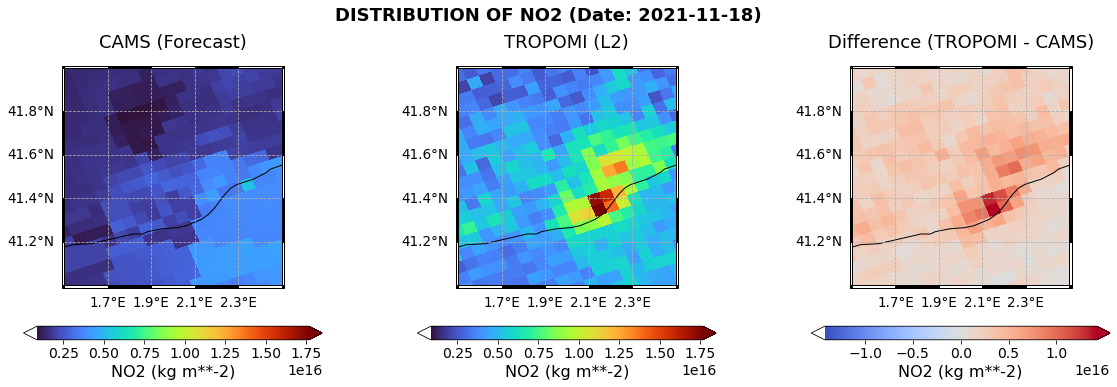

In [49]:
# Choose distribution (aggregated, individual or animated)
distribution_type = 'individual'

# Choose range (original, equal or manual)
range_type = 'equal'
vmin_manual = None
vmax_manual = None

# Define projection and colors
projection = ccrs.PlateCarree()
color_scale = ['turbo', 'turbo', 'coolwarm']

# Get and decide the best width and height of the B/W frame lines
options_height_lon = get_frame_possible_lengths(lon_min, lon_max)
options_width_lat = get_frame_possible_lengths(lat_min, lat_max)
width_lon = 0.2
height_lat = 0.2

visualize_model_vs_sensor(model, sensor, component_nom, units, merge_df, plot_dates, plot_bbox, 20, 1.05, 
                          model_type, sensor_type, range_type, distribution_type, projection,
                          color_scale, width_lon, height_lat, vmin_manual, vmax_manual)

### Retrieve nearest values to specific coordinates

It is possible to see the variations of nitrogen dioxide by CAMS and TROPOMI for multiple times and locations. The toolbox will find the nearest neighbours to the input coordinates (`coords_search_list`) and show a table with the concentrations, along with a timeseries plot. In this case, we only have one timestep, so the timeseries plot will not be visible.

In [50]:
regions_names = ('Barcelona - 1', 'Barcelona - 2')
coords_list = (41.39, 2.15,
               41.1, 1.65)
ymin = 0
ymax = 5*10**15
xticks = plot_dates

timeseries_table = timeseries(merge_df.dropna(), component_nom, sensor, sensor_type, model, 
                              plot_dates, units, ymin, ymax, xticks, regions_names, coords_list)
timeseries_table

,,,,,,ground_pixel,scanline,model_column,sensor_column,difference,relative_difference
region,lat_search,lon_search,latitude,longitude,time,,,,,,
Barcelona - 1,41.39,2.15,41.399746,2.131355,2021-11-18,116.0,3303.0,3.884993e+15,1.711462e+16,1.322962e+16,-0.773001
Barcelona - 2,41.10,1.65,41.075066,1.639530,2021-11-18,106.0,3300.0,1.567914e+15,3.974105e+15,2.406191e+15,-0.605467


### Scatter plots by bbox

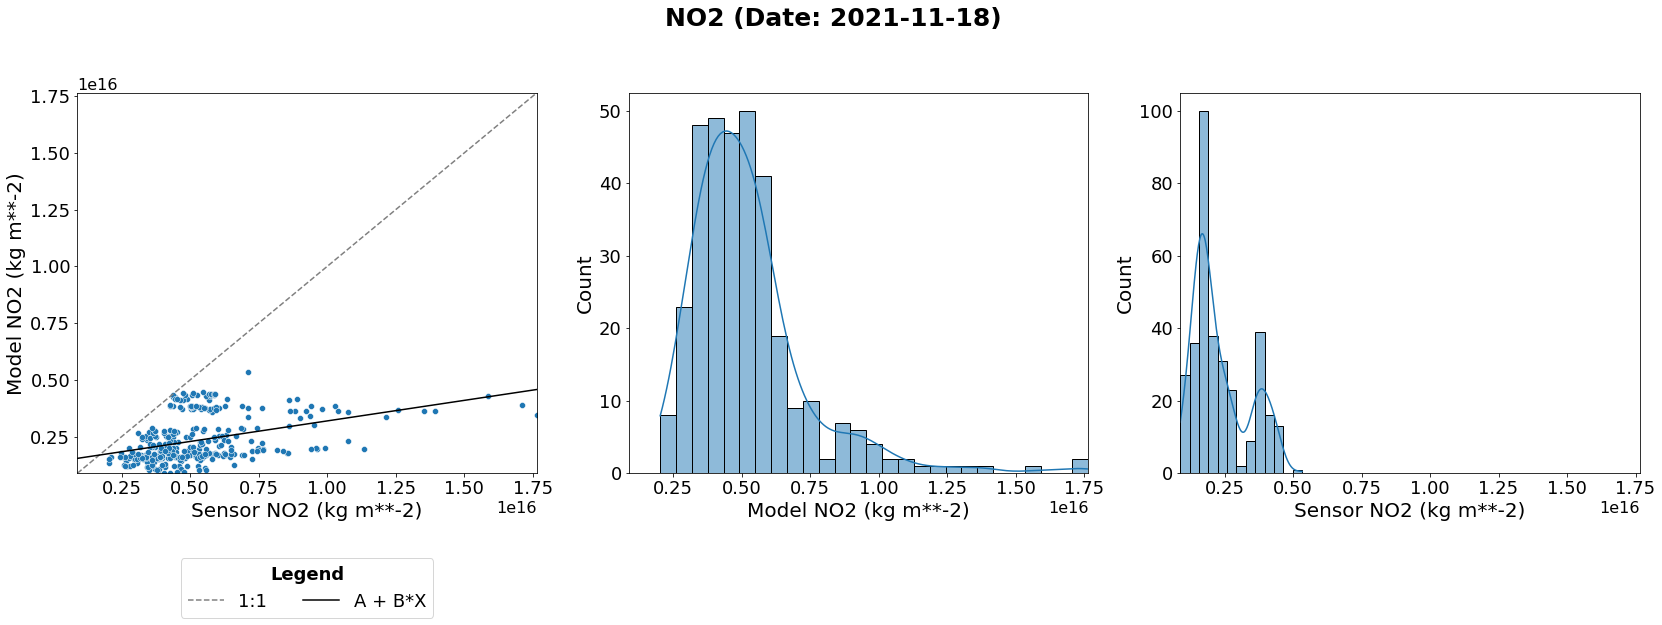

,Period,Location,A,B,R2,RMSE,MSE
0,2021-11-18,"((1.5, 41), (2.5, 42))",0.181031,1.376865e+15,0.161559,9.115117e+14,8.308537e+29


In [51]:
show_seasons = False
extent_definition = 'bbox' # bbox or country
scatter_plot_type = 'individual' # aggregated or individual

lim_min = None
lim_max = None

summary = scatter_plot(merge_df.dropna(), component_nom, units, sensor, plot_dates, 1.05, 
                       extent_definition, show_seasons, scatter_plot_type, lim_min, lim_max, plot_bbox)
summary

### Scatter plots by season

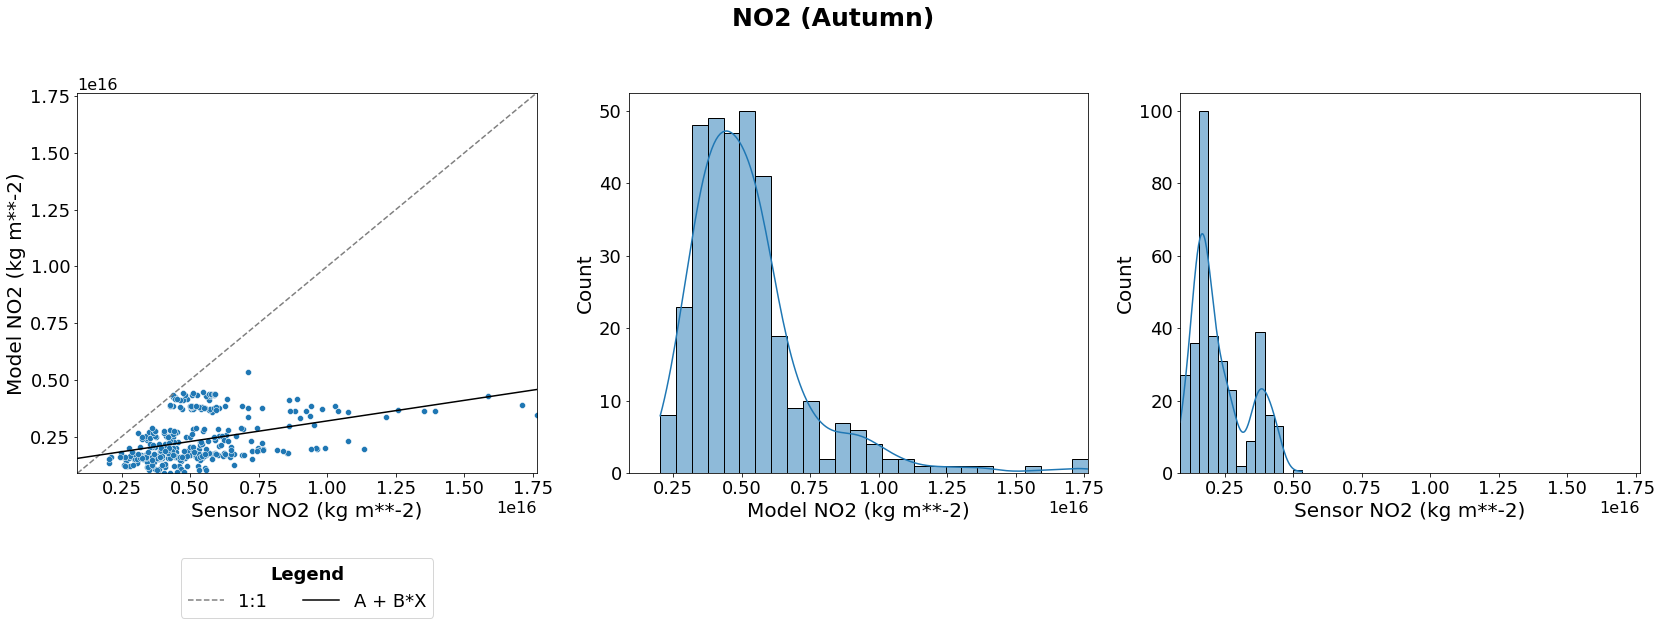

,Period,Location,A,B,R2,RMSE,MSE
0,Autumn,"((1.5, 41), (2.5, 42))",0.181031,1.376865e+15,0.161559,9.115117e+14,8.308537e+29


In [52]:
show_seasons = True
extent_definition = 'bbox' # bbox or country
scatter_plot_type = 'individual' # aggregated or individual

lim_min = None
lim_max = None

summary = scatter_plot(merge_df.dropna(), component_nom, units, sensor, plot_dates, 1.05, 
                       extent_definition, show_seasons, scatter_plot_type, lim_min, lim_max, plot_bbox)
summary

## <a id='assignment'>5. Assignment</a>

After learning about the ADC Toolbox during the training, participants will be able to carry out their own studies and explore its capabilities by completing one of these assignments:

1. Use the satellite NO<sub>2</sub> concentrations in your own city for a day in the last month and show how CAMS and TROPOMI datasets compare to each other applying TROPOMI averaging kernels to the CAMS data (using this notebook). As a bonus, compare both datasets without using the kernels or run a timeseries animated comparison (using <em>main_cams_tropomi_L2.ipynb</em>).

2. Compare the CAMS model and IASI sensor datasets to see if the COVID-19 lockdowns helped to reduce the air pollution in your region by looking at the monthly data of CO between 2019 and 2021 (using <em>main_cams_iasi_L3.ipynb</em>). There are other factors that might affect the data, could you think of which ones may cause variations in the concentrations of CO?

You can find <a href = "https://padlet.com/GlasgowsEvents/os1kfgsk1z679dk2" target = "_blank">all the submissions in Padlet</a>.

## <a id='faq'>6. FAQ and common errors</a>

The frequently asked questions and errors have been collected as:

* <strong>When importing libraries, I get the error <em>"ModuleNotFoundError: No module named 'sentinelsat'"</em></strong>: This occurs when the virtual environment is not activated. If you have followed the installation instructions and the virtual environment has been created, you need to select it on the top right of the page (Figure 2).

<img src='images/Kernel_selection.png' align='center' width='100%'></img>

<center><b>Figure 2.</b> Kernel selection location in JupyterHub.</center>

* <strong>When downloading the CAMS dataset, the compiler is showing the error <em>"TypeError: 'tuple' object is not callable"</em></strong>: This usually happens when the user ID and API key are not well defined. If you have given the variables CAMS_UID and CAMS_key a string other than None, remember to quote it with double or single quotes. If you want to run the other notebooks, it is recommend to create a text file in the <em>data</em> folder, with the name <em>keys.txt</em>, and write down your personal ID and CAMS API key in one line with the format <em>UID:Key</em>. An example can be found in the folder <em>2021-12-atmospheric-composition</em>.

* <strong>The installation of the toolbox in WEkEO takes too long. Is this normal?</strong>: It should take about 10 minutes to install through the terminal.

* <strong>The kernel is suddenly not working and I have to run the entire code again</strong>: If this happens, please contact WEkEO's support (support@wekeo.eu). It is likely that there is a problem with your personal account. It is also possible that you are using too many computational resources (e.g. by selecting a very large bounding box or time period).

If you have any other question or comment, you can <a href = "https://github.com/esowc/adc-toolbox/issues" target = "_blank">open an issue in GitHub</a>.

## <a id='feedback'>7. User feeback form</a>

If you are interested in the ADC toolbox and would like it to have other functionalities or datasets, you can <a href = "https://docs.google.com/forms/d/e/1FAIpQLSd2DYumvDcIGIz1cQrbfezOOEdGBFli5q76uZvmLva6mZ0E7w/viewform?usp=sf_link" target = "_blank">write your feedback in this Google Form</a>. 

<center><strong>Thank you very much!</strong></center>

<img src='images/Joint_school_logo_line.png' align='center' width='100%'></img>